In [52]:
import wandb
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import gymnasium as gym
import numpy as np
import plotly.express as px
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from environments.mujoco_gymnasium.contact_wrapped_antv5 import ContactForceWrapper

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
class ObservationHistoryCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(ObservationHistoryCallback, self).__init__(verbose)
        self.observation_history = []

    def _on_step(self) -> bool:
        # Access the current observation
        rollout_buffer = self.model.rollout_buffer
        for obs in rollout_buffer.observations:
            self.observation_history.append(obs)
        return True

    def get_observation_history(self):
        return np.array(self.observation_history)

In [ ]:
# Initialize wandb
wandb.init(project="ant-ppo", sync_tensorboard=True, name="ppo_ant_run")

# Wrap env to include contact forces
# env = gym.make("Ant-v5")
# foot_geom_names = ["left_ankle_geom", "right_ankle_geom", "third_ankle_geom", "fourth_ankle_geom"]
# env = ContactForceWrapper(env, foot_geom_names)


# Training setup
logdir = "./logs/ant_ppo"
env_train = ContactForceWrapper(gym.make("Ant-v5"), foot_geom_names)
model = PPO("MlpPolicy", env_train, verbose=1, tensorboard_log=logdir, batch_size=2048, n_steps=2048, learning_rate=3e-4, device="cpu")

# Use the custom callback
obs_callback = ObservationHistoryCallback()
model.learn(total_timesteps=10, callback=obs_callback)  # Increase timesteps for better policy

# Save the model
model.save("models/ppo_antv5")

# Retrieve and save the observation history
observation_history = obs_callback.get_observation_history()
np.save(f"{logdir}/observation_history.npy", observation_history)

# Finish wandb
wandb.finish()

# Close the environment
env_train.close()

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/ant_ppo/PPO_11
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 133      |
|    ep_rew_mean     | -150     |
| time/              |          |
|    fps             | 1547     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------


global_step,▁▁▁
rollout/ep_len_mean,▁
rollout/ep_rew_mean,▁
time/fps,▁
global_step,2048
rollout/ep_len_mean,132.63637
rollout/ep_rew_mean,-149.99649
time/fps,1547


## Visualize Rollout History

In [ ]:
obs_history = np.load("observation_history.npy")
# obs_history = obs_history.reshape(-1, obs_history.shape[-1])
obs_history = obs_history.squeeze()
print(obs_history.shape)

timesteps_to_show = 1000
x = np.arange(timesteps_to_show)
fig = px.line(x=x, y=obs_history[:timesteps_to_show, 111], title='Observation History')
fig.show()

def active_contact_mode():
    leg_force_indices = np.arange(105, 117)

    for leg in range(4):
        leg_force_norm = np.linalg.norm(obs_history[:, leg_force_indices[leg*3: (leg+1)*3]], axis=1)
        print(f"Leg {leg} force norm over time:", leg_force_norm)

    np.linalg.norm
    contact_modes = (contact_forces > 1e-2).astype(int)
    return contact_modes


(4194304, 117)


##

## Define a Dataset Class for Hybrid System Identification

In [55]:
from hybrid_sys_id_algorithms.hybrid_sysid_dataset import HybridSystemIdentificationDataset
from hybrid_sys_id_algorithms.hybrid_sysid_classifier import ModeClassifier

dataset = HybridSystemIdentificationDataset(observation_history=obs_history, num_legs=4, contact_force_dim=3, contact_force_start_idx=105)
# df = dataset.make_mode_label_dataframe()
# df.head()
# dataset[100000]

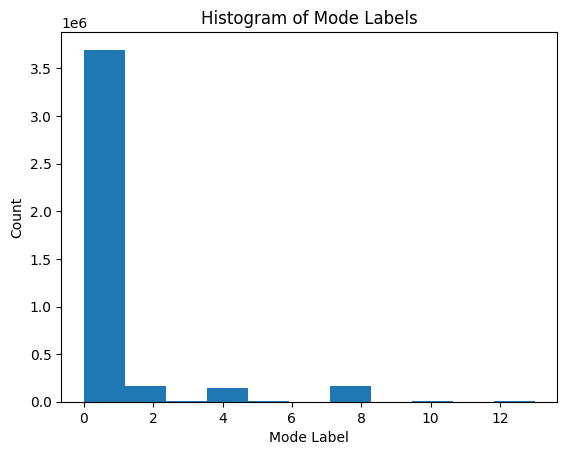

In [53]:
dataset.df["mode_label"].plot.hist(bins=len(dataset.df["mode_label"].unique()))
plt.xlabel("Mode Label")
plt.ylabel("Count")
plt.title("Histogram of Mode Labels")
plt.show()

In [ ]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn


# Assume dataset is already created
# dataset = HybridSystemIdentificationDataset(...)

batch_size = 64
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Get input/output dimensions
input_dim = dataset[0]["observation"].shape[0]
num_modes = int(max(dataset.mode_labels)) + 1  # or len(np.unique(dataset.mode_labels))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModeClassifier(input_dim, hidden_dim = 128, num_hidden_layers=2, num_classes=num_modes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    model.train()
    for batch in loader:
        obs = batch["observation"].float().to(device)  # shape: (batch, obs_dim)
        labels = batch["mode_label"].long().to(device) # shape: (batch,)
        
        logits = model(obs)                            # shape: (batch, num_modes)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 0.0000
Epoch 1: Loss = 0.0000
Epoch 2: Loss = 0.0000
